In [3]:
import pandas as pd
import numpy as np
import json
from pathlib import Path 
import itertools
from datetime import datetime

from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl

import pickle as pk
from sectioning.dataloader import TextTurnsDataModule
from sectioning.model import TextTurnsTagger

#formatting
pd.options.display.max_colwidth = 500
pd.options.display.max_rows=100


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    cuda_device = torch.cuda.current_device()
else:
    device = torch.device("cpu")
    cuda_device = -1

# Generate Predictions for all sentences

In [5]:
df = pd.read_pickle('datasets/train_sent.pkl')

In [8]:
LABEL_COLUMNS = [] #name your labels here

In [6]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-base")
special_token_dict = {'additional_special_tokens':['<START>','<END>']}
tokenizer.add_special_tokens(special_token_dict)

In [ ]:
#modifying the model to make it output embeddings
class TextTurnsTagger(pl.LightningModule):
    def __init__(self, n_classes: int, tokenizer, n_training_steps=None, n_warmup_steps=None, multi_label=True):
        super().__init__()
        self.bert = AutoModel.from_pretrained("johngiorgi/declutr-base")
        self.bert.resize_token_embeddings(len(tokenizer))
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.multi_label = multi_label
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        embs = output[0]
        output = self.classifier(output.pooler_output)
        if self.multi_label:
            output = torch.sigmoid(output)

        loss = 0
        if labels is not None:
            if self.multi_label:
                loss = self.criterion(output, labels)
            else:
                loss = nn.functional.cross_entropy(output, labels.argmax(dim=-1))
        if self.multi_label:
            return loss, output
        else:
            return loss, nn.functional.softmax(output, dim=-1), embs
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs,embs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels, "embs":embs}
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.log({f"{name}_roc_auc/Train": class_roc_auc})
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )

In [ ]:
trained_model = TextTurnsTagger(
  n_classes=len(LABEL_COLUMNS)
)
trained_model.load_state_dict(
  torch.load('models/model_sent.ckpt') 
)

In [ ]:
data_loader = TextTurnsDataModule(df_pro, df_pro, tokenizer, batch_size = 256)
data_loader.setup()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
trained_model.eval()

predictions = []
embeddings = []
for batch in tqdm(data_loader.test_dataloader(),total=len(df_pro)//256):
    with torch.no_grad():
        _, prediction,embs = trained_model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
              )
    
    embeddings = torch.sum(
        embeddings * attention_mask.unsqueeze(-1), dim=1
    ) / torch.clamp(torch.sum(attention_mask, dim=1, keepdims=True), min=1e-9)
    
    predictions += list(prediction.detach().cpu())
    embeddings += list(embs.detach().cpu())

In [ ]:
predictions = torch.stack(predictions)
embeddings = torch.stack(predictions).numpy()

In [ ]:
pred_idxs = predictions.argmax(dim=1)
pred_idxs = pred_idxs.reshape(pred_idxs.shape[0], 1)
pred_from_idx = torch.zeros(predictions.shape)
pred_from_idx.scatter_(1, pred_idxs, 1.)

In [ ]:
df['embeddings'] = embeddings
for i, label in enumerate(LABEL_COLUMNS):
    pred = label+'_pred'
    df[pred] = red_from_idx[:,i]

# Clustering

In [ ]:
df_to_be_clustered = df.loc[df['your_pred_1']==1] 
# change "your_pred_1" to the column of label you are willing to cluster



In [8]:
import umap
import umap.plot

In [ ]:
emb_dict_all = {}
for idx, row in tqdm(df_to_be_clustered.iterrows(), total=len(df_to_be_clustered)):
    emb_dict_all[row['text']] = emb_dict_all[row['embeddings']]
    
    

In [ ]:
embeddings = list(emb_dict_all.values())

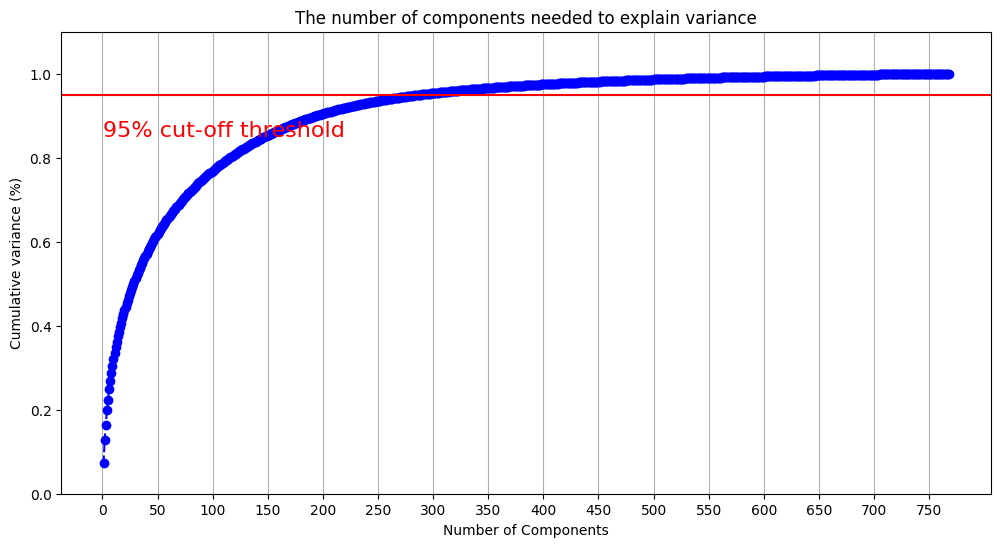

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(embeddings)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 769, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 768, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
lowd_embs = PCA(n_components=250).fit_transform(embeddings)

In [ ]:
import sklearn.cluster as cluster
def draw_elbow(embeddings, num_of_turns=10):
    distortions = []
    K = range(1,num_of_turns)
    for k in K:
        kmeanModel = cluster.KMeans(init='k-means++', n_clusters=k)
        kmeanModel.fit(embeddings)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


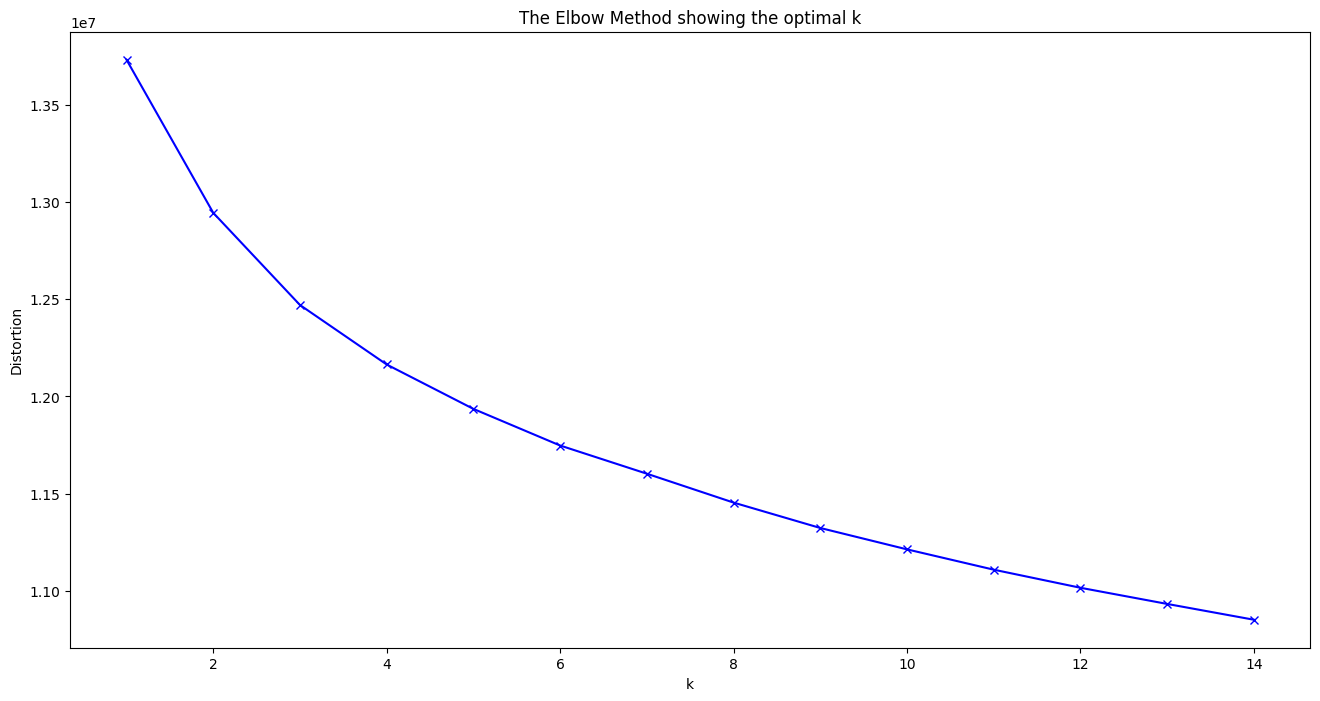

In [50]:
draw_elbow(lowd_embs, 15)

In [35]:
reducer = umap.UMAP(n_components=50, 
                    n_neighbors=30, 
                    min_dist=0.0, 
                    random_state=42, 
                    transform_seed=42, 
                    verbose=False)

embedding_umap = reducer.fit_transform(lowd_embs)



In [36]:
import sklearn.cluster as cluster
de_kmeans_labels_pca_enh = cluster.KMeans(init='k-means++',n_clusters=10).fit_predict(embedding_umap)

In [37]:
label_dict = {}
sents = list(emb_dict_all.keys())
for i in range(len(sents)):
    label_dict[sents[i]] = de_kmeans_labels_pca_enh[i]

In [38]:
#no PCA
#visualization of 30000 data points
reducer = umap.UMAP(random_state = 42)
embedding_umap_viz = reducer.fit(lowd_embs[:30000])
hover_data = pd.DataFrame({'index':range(0,30000),
                           'label':list(label_dict.values())[:30000],
                           'text':list(label_dict.keys())[:30000]})
p1 = umap.plot.interactive(embedding_umap_viz, labels=list(label_dict.values())[:30000], hover_data=hover_data, point_size=2)


In [39]:
umap.plot.output_notebook()

Loading BokehJS ...

In [40]:
umap.plot.show(p1)

In [ ]:
# The data points are again ready to be used for updating your pseudo labels.